In [30]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt 
import cartopy
import cartopy.crs as ccrs
import cftime
from datetime import date, timedelta

In [31]:
case = "fanv3_1th"
path = "/glade/scratch/jinmuluo/archive/" + case + "/lnd/hist/" 
start_date = date(2012, 12, 1)
end_date = date(2013, 1, 1)
delta = end_date - start_date
fields = ["N2O_DENITRIFY_TOTAL", "N2O_NITRIFY_TOTAL", "NOx_DENITRIFY_TOTAL", "NOx_NITRIFY_TOTAL", "area"]
fanCLM = []
for i in range(delta.days + 1):
    day = start_date + timedelta(days=i)
    day = day.strftime('%Y-%m-%d')
    fanCLM.append(path + case + ".clm2.h6." + day +"-00000.nc")
print(fanCLM[-1])

/glade/scratch/jinmuluo/archive/fanv3_1th/lnd/hist/fanv3_1th.clm2.h6.2013-01-01-00000.nc


In [14]:
def preprocess (ds, fields = fields):
    return(ds[fields])

def fix_time(ds):  
    ndays = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D')    
    return ds

dsCLM = fix_time(xr.open_mfdataset(fanCLM, decode_times=True, preprocess=preprocess))
dsCLM

<xarray.Dataset>
Dimensions:              (time: 17569, lat: 96, lon: 144)
Coordinates:
  * time                 (time) object 2012-01-01 00:00:00 ... 2060-02-06 00:...
  * lon                  (lon) float32 0.0 2.5 5.0 7.5 ... 352.5 355.0 357.5
  * lat                  (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
Data variables:
    N2O_DENITRIFY_TOTAL  (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
    N2O_NITRIFY_TOTAL    (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
    NOx_DENITRIFY_TOTAL  (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
    NOx_NITRIFY_TOTAL    (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
    area                 (time, lat, lon) float32 dask.array<chunksize=(48, 96, 144), meta=np.ndarray>
Attributes: (12/101)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 01/16/23 16:18:28
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    cft_irrigated_tropical_corn:          62
    cft_tropical_soybean:                 63
    cft_irrigated_tropical_soybean:       64
    time_period_freq:                     minute_30
    Time_constant_3Dvars_filename:        ./fanv3_1th.clm2.h4.2010-01-01-0000...
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [27]:
def sp_plot(ds, field, coords, show=False):
    sp = ds.sel(lat=coords[0], lon=coords[1], method='nearest')
    # gN/m2/s to kg/day
    sp[field] = sp[field] * sp['area'] * 1000 * 24 * 3600
    if show:
        sp[field].plot()
        plt.show()
    return result

In [28]:
def tot_plot(ds, field, show=False):
    # calculate global total emission (kg/day)
    total = ds[field]*ds['area']* 1000 * 24 * 3600
    total.sum(skipnan=True, dim=[1, 2])
    if show:
        total.plot(x='time')
        plt.show()
    return total

In [11]:
def regional_plot(ds, field, coords, show=False):
    x = slice(coords['lower_lat'], coords['upper_lat'])
    y = slice(coords['west_lon'], coords['east_lon'])
    sp = ds[field].sel(lat=x, lon=y).sum(skipnan=True, dim=[1, 2])
    if show:
        sp.plot(x='time')
        plt.show()
    return 0

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

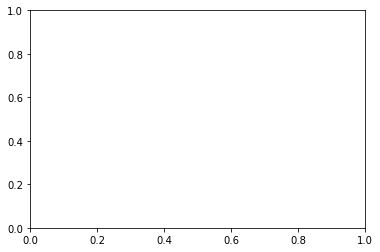

In [ ]:
coordinates = [23.45, 130.25]
sp_plot(ds=dsCLM, field=fields[0], coords=coordinates, show=True)

In [29]:
tot_plot(ds=dsCLM, field=fields[0], show=True)

ValueError: 1 not found in array dimensions ('time', 'lat', 'lon')

In [3]:
coordinates = {'upper_lat':45.50, 'lower_lat':25.35, 'west_lon': 100.00, 'east_lon':130.00}
regional_plot(ds=dsCLM, field=fields[0], coords=coordinates, show=True)

NameError: name 'regional_plot' is not defined